# Predicting the tag for Stack Overflow questions (multi-class classification)


In this project,we develop a model that predicts the tag for a question. The notebook starts with the simplest text processing algorithms (like Bag of Words) and continuous to more complex models(like RNNs, LSTM, ...).

 Each question (for example: "How do I sort a dictionary by value?") is labeled with exactly one of the four tags:
 * Python
 * CSharp
 * JavaScript
 * Java

As our dataset, we use a dataset of 8,000 programming questions from Stack Overflow. Each question is labeld by one of the mentioned tags.




## Loading libraries

In [1]:
#importing the required libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1,l2

## Creating data sets

In [2]:
#importing the data
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'
target_dir = "/content/sample_data/stack_overflow_questions" #we want to store our data in this directory

#creating while ckecing the existance of the mentioned directory
os.makedirs(target_dir, exist_ok=True)

#loading the file
loaded_file = tf.keras.utils.get_file(origin= data_url, cache_dir = target_dir,
                                      untar = True, cache_subdir = "")


6053168/6053168 [==============================] - 0s 0us/step


In [3]:
#using pathlib library to show the content of the directory

list(pathlib.Path(loaded_file).parent.iterdir())

[PosixPath('/content/sample_data/stack_overflow_questions/test'),
 PosixPath('/content/sample_data/stack_overflow_questions/train'),
 PosixPath('/content/sample_data/stack_overflow_questions/README.md'),
 PosixPath('/content/sample_data/stack_overflow_questions/stack_overflow_16k.tar.gz')]

In [4]:
# we can alos use the os library is an alternative to the pathlib library
os.listdir(os.path.dirname(loaded_file))

['test', 'train', 'README.md', 'stack_overflow_16k.tar.gz']

In [5]:
#creating a separated directory for the training data
train_path_dir = pathlib.Path(loaded_file).parent/'train'
train_path_dir

PosixPath('/content/sample_data/stack_overflow_questions/train')

In [6]:
#creating a separated directory for the test data
test_path_dir = pathlib.Path(loaded_file).parent/'test'
test_path_dir

PosixPath('/content/sample_data/stack_overflow_questions/test')

At this step, we create the training dataset by using 80% of our data. We should also set the same seed_value for both the training and validation datasets to avoide having repetitive observations.

We als batch our data in sizes of 64 to fasten the performance of our models.

In [7]:
#loading the data as a td.data.Data object and creating the training data set
train_ds = tf.keras.utils.text_dataset_from_directory(train_path_dir,
                                                      batch_size = 64,
                                                      subset = 'training',
                                                      seed = 30,
                                                      validation_split = 0.2)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [8]:
# creating the validation dataset
val_ds = tf.keras.utils.text_dataset_from_directory(train_path_dir,
                                                      batch_size = 64,
                                                      subset = 'validation',
                                                      seed = 30,
                                                      validation_split = 0.2)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [9]:
# creating the test dataset
test_ds = tf.keras.utils.text_dataset_from_directory(test_path_dir,
                                                      batch_size = 64)

Found 8000 files belonging to 4 classes.


## Showing some observations

In [10]:
# showing the lables(tags) of the datasets
labels = train_ds.class_names
labels


['csharp', 'java', 'javascript', 'python']

In [11]:
# showing questions and their labels(tags)
for example, label in train_ds.take(1):
  for i in range(9):
    print('question text:', example.numpy()[i])
    print('the assigned label:',labels[label.numpy()[i]],'\n')

question text: b'can an arraylist of node contain non-node type? can an arraylist of node contain a non-node type? ..is there a very dirty method of doing this with type casting?\n'
the assigned label: java 

question text: b'"delete and add object at same index in nested object object : ..var userdata = {.  ""a1"":{""a"":""1""},.  ""b2"":{""b"":""2""},.  ""c3"":{""c"":""3""},.  ""d4"":{""d"":""4""},.  ""e5"":{""e"":""5""},.};...i need to delete object with key ""a1"" and place a new object i.e. ""f6"" at same place..i.e.  ..userdata[""f6""] = userdata[""a1""];.userdata[""f6""].new = ""true""; .delete userdata[""a1""];  ...output:  ..userdata = {.  ""b2"":{""b"":""2""},.  ""c3"":{""c"":""3""},.  ""d4"":{""d"":""4""},.  ""e5"":{""e"":""5""},  .  ""f6"":{""a"":""1"", new:true},.};   ...expected o/p:  ..var userdata = {.  ""f6"":{""a"":""1"", new:true},.  ""b2"":{""b"":""2""},.  ""c3"":{""c"":""3""},.  ""d4"":{""d"":""4""},.  ""e5"":{""e"":""5""},.};   ...thanks in advance.."\n'
the assig

## Optimizing for performance

At this step, we apply two methods:
1. cach(): Caching helps avoid redundant loading and preprocessing of data during each epoch. Once the data is loaded and processed, it stays in memory, speeding up subsequent iterations through the dataset.
2. prefetch(): By prefetching data, the CPU and GPU can work in parallel, reducing idle time and making better use of system resources.

In [12]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

## Text Vectorization

At this step, we want to create our vocabulary dictionary(lexicon).


In [13]:
#creating the tokeization layer and vocabualry dictionray
vocab_size = 10000 # the length of our lexicon
tokenizer_binary = layers.TextVectorization(max_tokens = vocab_size, output_mode = 'binary') # using binary output mode results in a bag of words of tokens
train_ds_text = train_ds.map(lambda text, label: text)
tokenizer_binary.adapt(train_ds_text) # creating the lexicon

In general, we can have two approaches for creating models: Bag of words and Word Embeddings




## Bag of words method
  * this model is the traditional, yet powerfull approach for solving some tasks.
  In a simple bag of words model, the focus is on representing a document based on the occurrence of words, disregarding their order or structure.
  * The model creates a vocabulary of unique words from the entire corpus (collection of documents). Each document is then represented as a fixed-size vector, where each element corresponds to the count (or presence/absence) of a word in the vocabulary.
  * This representation is often high-dimensional, and the vectors can be sparse, especially if the corpus is large and diverse.
  * This model is straightforward and computationally efficient, but it doesn't capture the semantic relationships between words or the order of words in a document.

At this step, we create the simple BOW(bag of words) model:

In [14]:
#using a sequential API to define the bag of words model(bow)
bow_model = tf.keras.Sequential([
    tokenizer_binary,
    layers.Dense(4)
])

In [15]:
# Compling the mode
bow_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],
    optimizer = 'adam'
)

In [16]:
# showing the summary of the model
bow_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 10000)             0         
 ctorization)                                                    
                                                                 
 dense (Dense)               (None, 4)                 40004     
                                                                 
Total params: 40004 (156.27 KB)
Trainable params: 40004 (156.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


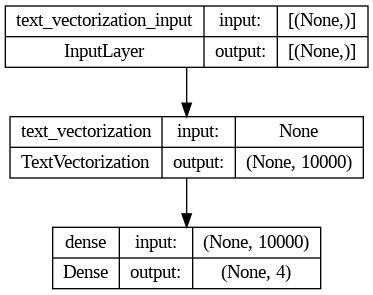

In [17]:
# plotting the BOW model
tf.keras.utils.plot_model(bow_model, show_shapes = True)

In [18]:
# training the model with 20 epochs
EPOCHS = 20
bow_model_history = bow_model.fit(train_ds, validation_data= val_ds, epochs = EPOCHS)

Epoch 1/20
100/100 [==============================] - 7s 11ms/step - loss: 1.1912 - accuracy: 0.6119 - val_loss: 1.0361 - val_accuracy: 0.7337
Epoch 2/20
100/100 [==============================] - 1s 9ms/step - loss: 0.8918 - accuracy: 0.8058 - val_loss: 0.8739 - val_accuracy: 0.7675
Epoch 3/20
100/100 [==============================] - 1s 8ms/step - loss: 0.7364 - accuracy: 0.8422 - val_loss: 0.7809 - val_accuracy: 0.7856
Epoch 4/20
100/100 [==============================] - 1s 8ms/step - loss: 0.6365 - accuracy: 0.8648 - val_loss: 0.7200 - val_accuracy: 0.7950
Epoch 5/20
100/100 [==============================] - 1s 9ms/step - loss: 0.5648 - accuracy: 0.8878 - val_loss: 0.6769 - val_accuracy: 0.7962
Epoch 6/20
100/100 [==============================] - 1s 9ms/step - loss: 0.5098 - accuracy: 0.9023 - val_loss: 0.6447 - val_accuracy: 0.8031
Epoch 7/20
100/100 [==============================] - 1s 8ms/step - loss: 0.4656 - accuracy: 0.9123 - val_loss: 0.6198 - val_accuracy: 0.8081
Epoch

In [19]:
# creating a dictionary to store all the following results as data frames
model_comparison = {}
model_comparison["bow_model"] = pd.DataFrame(bow_model_history.history)


### Plotting the training and validation curves
Here I create a function to show the performance of models to better understand what happens inside them while training.

In [20]:
# using plt.subplot method and matplotlib to create the function
def plot_performance(model_name, epochs = EPOCHS):
  dataframe = model_comparison[model_name]
  plt.figure(figsize = (12,3))

  plt.subplot(1,2,1)
  plt.plot(dataframe[["val_loss", "loss"]])
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Loss")
  plt.legend(["val_loss", "loss"])

  plt.subplot(1,2,2)
  plt.plot(dataframe[["val_accuracy", "accuracy"]])
  plt.legend(["val_accuracy", "accuracy"], loc = "upper left")
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Accuracy")



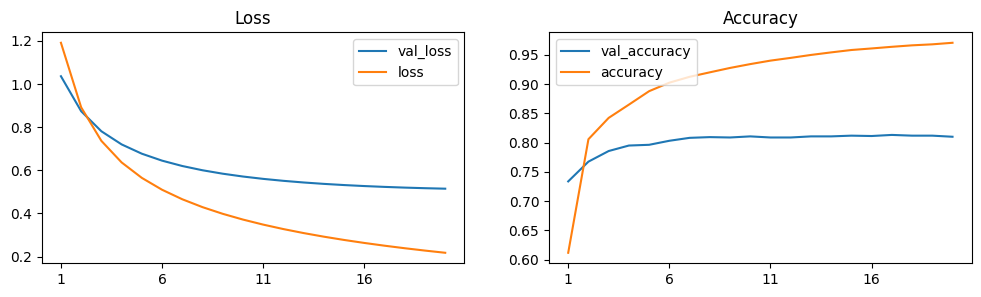

In [21]:
# plotting bag of words model performance
plot_performance("bow_model")

As we can see, the accuracy of the validation set after almost the 6th epoch didn't increase, while the training set accuracy increases up to around 97%. It shows that although the bag of word model can learn some patterns in the trianing set, it can't be easily generalized to unseen data. We can go further and pursue techniques to avoid overfitting, but our aim at this notebook is to compare the base line performance of different models; So, we keep models at their base level.

## Word Embeddings

 * a model with word embeddings takes a more sophisticated approach to represent words. Instead of using a sparse and high-dimensional representation like in the bag of words model, it uses dense, continuous-valued vectors called word embeddings.
 * These are learned representations that capture semantic relationships between words. Words with similar meanings are represented by vectors that are closer together.
 * The advantage of word embeddings is that they can capture semantic nuances and relationships between words, even those that may not occur frequently in the training data. This makes them particularly useful in tasks where understanding the meaning and context of words is crucial

***Creating toeknizer***

* To create word embeddings using keras API, we should set the output_mode = int and then pass the outcome to an Embeddings layer.

* when we use output_mode = int, we should determine the output sequence length. Determining the output_sequence_length parameter results in a tensor of shape [batch_size, output_sequence_length] regardless of how many tokens resulted from the splitting step and truncates sentences longer than the mentioned value(and pads with zero for sentences smaller than the mentioned value).

In [22]:
#using int output
OUTPUT_LENGTH = 100
tokenizer_int = layers.TextVectorization(output_mode= 'int', max_tokens = vocab_size, output_sequence_length=OUTPUT_LENGTH)
tokenizer_int.adapt(train_ds_text)

In [23]:
embedding_dim = 64 # the length of word embedding vectors will be 200
word_embedding_model = tf.keras.Sequential([
    tokenizer_int,
    layers.Embedding(vocab_size, embedding_dim, mask_zero = True),
    layers.GlobalAveragePooling1D(),
    layers.Dense(4, activation = 'softmax')
])

A short notice for the from_logits parameter:
* if in the last decision dense layer we've determined to activation function , we should'nt use from_logits = True in the sparse categorical cross entropy.
* but when we've just used a dense layer without determining the activation function, we are passing logits(raw data) in the loss function, so in this situation we should use from_logits = True in our loss function.

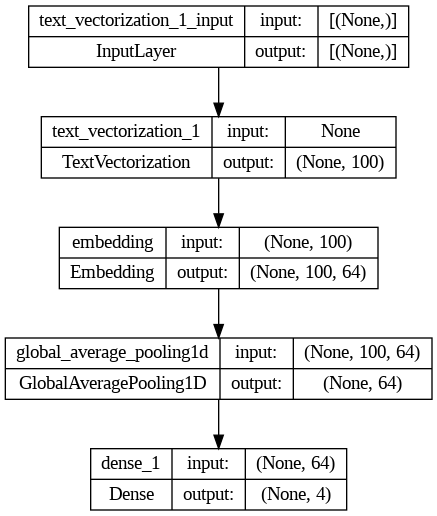

In [24]:
# compliling the model
word_embedding_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy'],
    optimizer = 'adam'
)

tf.keras.utils.plot_model(word_embedding_model, show_shapes = True)

In [25]:
# trining the model
word_embedding_model_history = word_embedding_model.fit(train_ds, validation_data= val_ds, epochs = EPOCHS)

Epoch 1/20
100/100 [==============================] - 15s 144ms/step - loss: 1.3642 - accuracy: 0.5000 - val_loss: 1.3337 - val_accuracy: 0.5875
Epoch 2/20
100/100 [==============================] - 1s 9ms/step - loss: 1.2578 - accuracy: 0.6898 - val_loss: 1.2080 - val_accuracy: 0.6388
Epoch 3/20
100/100 [==============================] - 1s 8ms/step - loss: 1.0828 - accuracy: 0.7423 - val_loss: 1.0577 - val_accuracy: 0.6775
Epoch 4/20
100/100 [==============================] - 1s 8ms/step - loss: 0.9090 - accuracy: 0.7764 - val_loss: 0.9360 - val_accuracy: 0.7006
Epoch 5/20
100/100 [==============================] - 1s 8ms/step - loss: 0.7718 - accuracy: 0.8062 - val_loss: 0.8502 - val_accuracy: 0.7150
Epoch 6/20
100/100 [==============================] - 1s 8ms/step - loss: 0.6678 - accuracy: 0.8280 - val_loss: 0.7904 - val_accuracy: 0.7250
Epoch 7/20
100/100 [==============================] - 1s 8ms/step - loss: 0.5866 - accuracy: 0.8462 - val_loss: 0.7477 - val_accuracy: 0.7325
Epo

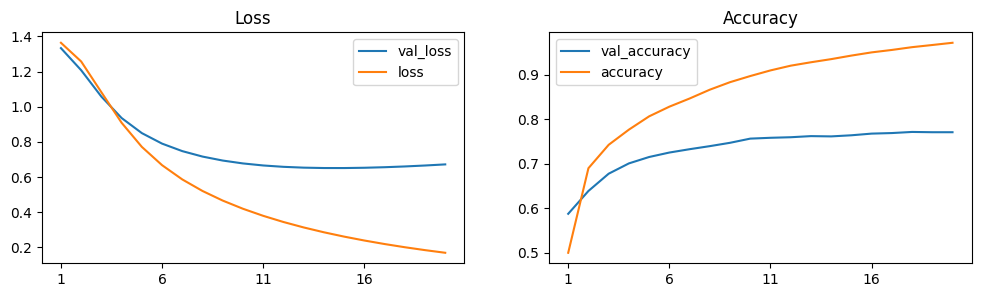

In [26]:
model_comparison["word_embedding"] = pd.DataFrame(word_embedding_model_history.history)
plot_performance("word_embedding")

The word embedding model showed almost the same behavior. It reached 77% validation accuracy, while this value decreased from the 10th epoch. To avoid this behavior, we apply a simple dropout regularization layer to the model after creating the word embeddings and create a new model:

In [27]:
word_embedding_regul_model = tf.keras.Sequential([
    tokenizer_int,
    layers.Embedding(vocab_size, embedding_dim, mask_zero = True),
    layers.Dropout(0.5), # switching off half of the vectors randomly at each iteration
    layers.GlobalAveragePooling1D(),
    layers.Dense(4, activation = 'softmax')
])

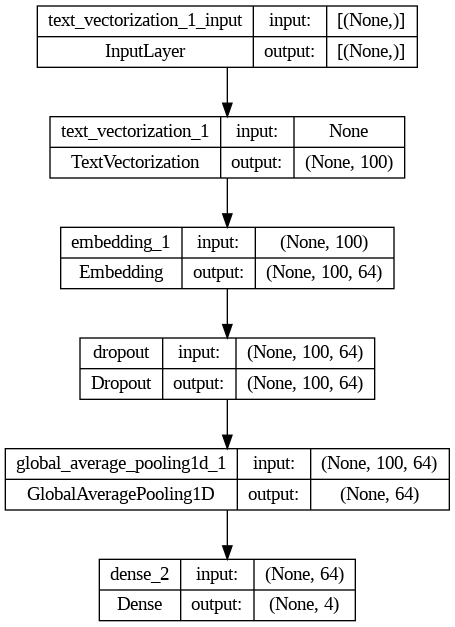

In [28]:
word_embedding_regul_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy'],
    optimizer = 'adam'
)

# show_shapes = True shows the dimensions of output result at each step
tf.keras.utils.plot_model(word_embedding_regul_model, show_shapes = True)

In [29]:
word_embedding_regul_history = word_embedding_regul_model.fit(train_ds, validation_data= val_ds, epochs= EPOCHS)

Epoch 1/20
100/100 [==============================] - 12s 100ms/step - loss: 1.3655 - accuracy: 0.5067 - val_loss: 1.3387 - val_accuracy: 0.5719
Epoch 2/20
100/100 [==============================] - 1s 8ms/step - loss: 1.2739 - accuracy: 0.6675 - val_loss: 1.2297 - val_accuracy: 0.6237
Epoch 3/20
100/100 [==============================] - 1s 8ms/step - loss: 1.1230 - accuracy: 0.7216 - val_loss: 1.0941 - val_accuracy: 0.6569
Epoch 4/20
100/100 [==============================] - 1s 8ms/step - loss: 0.9650 - accuracy: 0.7614 - val_loss: 0.9767 - val_accuracy: 0.6894
Epoch 5/20
100/100 [==============================] - 1s 8ms/step - loss: 0.8343 - accuracy: 0.7825 - val_loss: 0.8889 - val_accuracy: 0.7050
Epoch 6/20
100/100 [==============================] - 1s 13ms/step - loss: 0.7332 - accuracy: 0.8048 - val_loss: 0.8253 - val_accuracy: 0.7188
Epoch 7/20
100/100 [==============================] - 1s 9ms/step - loss: 0.6524 - accuracy: 0.8244 - val_loss: 0.7781 - val_accuracy: 0.7250
Ep

In [30]:
# saving model behavior in our comparion dictionary
model_comparison["word_embedding_regul"] = pd.DataFrame(word_embedding_regul_history.history)

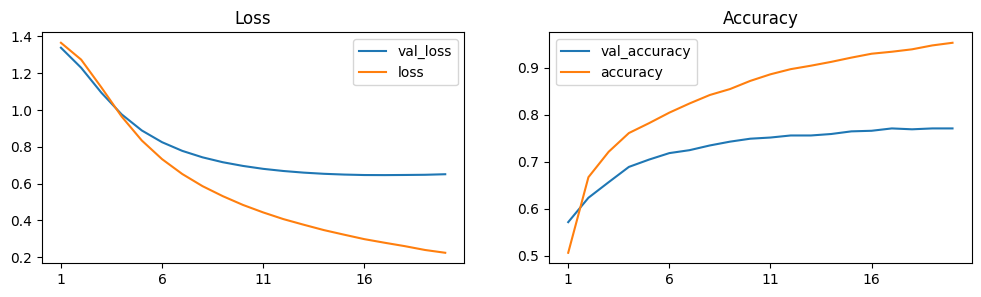

In [31]:
plot_performance("word_embedding_regul")

It showed no considerable changes! We need to get deeper in this model(which our usual job as a data scientist) or try a new structure(another part of our job!). We test RNN models at the next step.

## RNN model

In RNNs, unlike our approach in the bag of words model or simple word embeddings, we maintain a hidden state that captures information about previous inputs in the sequence. This hidden state is updated at each time step, allowing the network to retain memory of past information while processing new inputs. This makes RNNs suitable for tasks that involve sequential or time-dependent(in other words, any ordered data) patterns.

There are three built-in RNN layers in Keras:

1. keras.layers.SimpleRNN, a fully-connected RNN where the output from previous timestep is to be fed to next timestep.

2. keras.layers.GRU, first proposed in Cho et al., 2014.

3. keras.layers.LSTM, first proposed in Hochreiter & Schmidhuber, 1997.

First, we create a Fully-connected RNN where the output is to be fed back to input.

In [32]:
simple_rnn_model = tf.keras.Sequential([tokenizer_int,
                                       layers.Embedding(vocab_size,64, mask_zero = True),
                                       layers.Dropout(0.5),
                                       layers.SimpleRNN(128,kernel_regularizer=l2(0.02), recurrent_regularizer=l2(0.02)),
                                       layers.Dense(4, activation = 'softmax')
                                       ])

simple_rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 100, 64)           640000    
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               24704     
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 665220 (2.54 MB)
Trainable params: 665220 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

Since the number of paratmers are way more than the number of our trianing examples, we need to use regularization techiniques in our model. That's the reason I used two new regularization methods in this model, kernel regularizer and recurrent regularizer.
*  The kernel_regularizer parameter allows us to apply regularization specifically to the input weights.
* The recurrent_regularizer parameter is used to apply regularization the recurrent weights(hidden state weights).

In [33]:
# we use SparseCategoricalCrossentropy as our loss function since our target labels are not one hot encoded, they are integers:
simple_rnn_model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                             metrics = ['accuracy'])

In [34]:
simple_rnn_history = simple_rnn_model.fit(train_ds, validation_data = val_ds, epochs = EPOCHS)

Epoch 1/20
100/100 [==============================] - 25s 236ms/step - loss: 3.8631 - accuracy: 0.2616 - val_loss: 2.4689 - val_accuracy: 0.2688
Epoch 2/20
100/100 [==============================] - 16s 161ms/step - loss: 1.9097 - accuracy: 0.2975 - val_loss: 1.5778 - val_accuracy: 0.2587
Epoch 3/20
100/100 [==============================] - 17s 166ms/step - loss: 1.4734 - accuracy: 0.3159 - val_loss: 1.4188 - val_accuracy: 0.2688
Epoch 4/20
100/100 [==============================] - 16s 158ms/step - loss: 1.3973 - accuracy: 0.3578 - val_loss: 1.3944 - val_accuracy: 0.2663
Epoch 5/20
100/100 [==============================] - 16s 157ms/step - loss: 1.3795 - accuracy: 0.4039 - val_loss: 1.3939 - val_accuracy: 0.2844
Epoch 6/20
100/100 [==============================] - 18s 184ms/step - loss: 1.3592 - accuracy: 0.4455 - val_loss: 1.4045 - val_accuracy: 0.2894
Epoch 7/20
100/100 [==============================] - 16s 162ms/step - loss: 1.3212 - accuracy: 0.4564 - val_loss: 1.4307 - val_ac

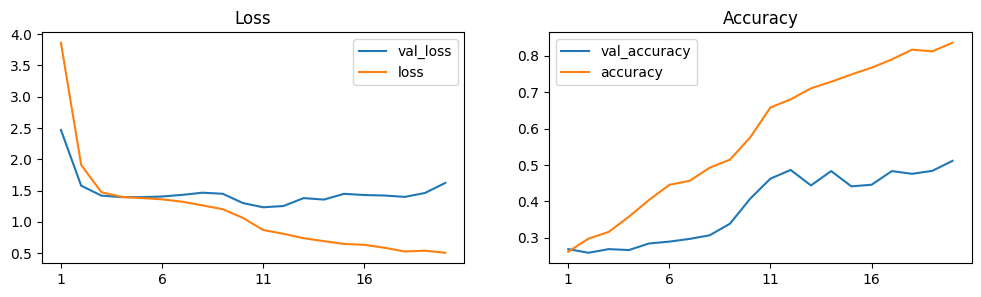

In [35]:
model_comparison["simple_rnn_model"] = pd.DataFrame(simple_rnn_history.history)
plot_performance("simple_rnn_model")

It demonstrated a way more learning capacity; Even after 20 epochs validation accuracy is still going up almost steadily. We can try train the model for a longer time, but due to computational power limitations and keeping all the models with the same number of epochs I won't go through it.

# RNN Model using LSTM

LSTM is a type of recurrent neural network (RNN) architecture designed to address the vanishing gradient problem (which is common in traditional RNNs). It includes memory cells and three gates (input, output, and forget gates) that regulate the flow of information through the network.

The LSTM layer processes the input sequences and maintains a hidden state and cell state. The hidden state represents the memory of the network and is updated at each time step.

In [36]:
rnn_lstm_model = tf.keras.Sequential([tokenizer_int,
                                       layers.Embedding(vocab_size,64, mask_zero = True),
                                       layers.LSTM(128, return_sequences= False, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
                                       layers.Dropout(0.3),
                                       layers.Dense(4, activation = 'softmax')
                                       ])
rnn_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 100, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 739332 (2.82 MB)
Trainable params: 739332 (2.82 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [37]:
rnn_lstm_model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                             metrics = ['accuracy'])

In [38]:
rnn_lstm_model_history = rnn_lstm_model.fit(train_ds, validation_data = val_ds, epochs = EPOCHS)

Epoch 1/20
100/100 [==============================] - 17s 114ms/step - loss: 2.0474 - accuracy: 0.2798 - val_loss: 1.4324 - val_accuracy: 0.2756
Epoch 2/20
100/100 [==============================] - 2s 17ms/step - loss: 1.1852 - accuracy: 0.4395 - val_loss: 1.1936 - val_accuracy: 0.4806
Epoch 3/20
100/100 [==============================] - 2s 16ms/step - loss: 0.9515 - accuracy: 0.5364 - val_loss: 1.0809 - val_accuracy: 0.4994
Epoch 4/20
100/100 [==============================] - 3s 28ms/step - loss: 0.7452 - accuracy: 0.7005 - val_loss: 0.9371 - val_accuracy: 0.6044
Epoch 5/20
100/100 [==============================] - 2s 17ms/step - loss: 0.5872 - accuracy: 0.7983 - val_loss: 0.8838 - val_accuracy: 0.6856
Epoch 6/20
100/100 [==============================] - 2s 16ms/step - loss: 0.4648 - accuracy: 0.8527 - val_loss: 0.8962 - val_accuracy: 0.7088
Epoch 7/20
100/100 [==============================] - 2s 16ms/step - loss: 0.4120 - accuracy: 0.8897 - val_loss: 0.8985 - val_accuracy: 0.72

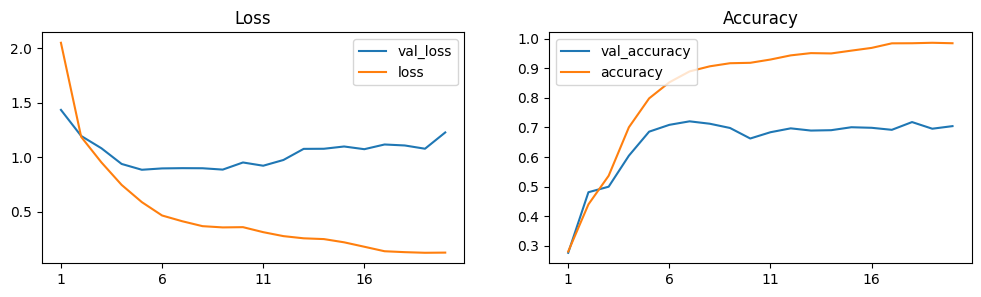

In [39]:
model_comparison['rnn_lstm'] = pd.DataFrame(rnn_lstm_model_history.history)
plot_performance('rnn_lstm')

The LSTM model showed an increase the validation loss after the 7th epoch. Maybe we should try early stopping as a callback in our model to avoid this behavior.

## RNN Model using Biderctional LSTM
In this approach, we create an encoder-decoder model. we can think of the word tokenizer as our encoder and the rest as our decoder. The Bidirectional LSTM is an extension of the traditional LSTM that processes the input sequence in both forward and backward directions. This allows the model to capture information from both past and future time steps,

In [40]:
# creating the encoder and vocabulary dictionary
encoder = layers.TextVectorization(max_tokens = vocab_size)

encoder.adapt(train_ds_text)


* A key benefit of utilizing a bidirectional RNN is that the information from the initial input doesn't have to traverse every timestep to impact the final output.
* However, a notable drawback of employing a bidirectional RNN is the inefficiency in streaming predictions as new words are appended to the end of the sequence.

In [41]:
model_rnn_bidir_lstm = tf.keras.Sequential([
    encoder,
    layers.Embedding(vocab_size, 64, mask_zero = True),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])



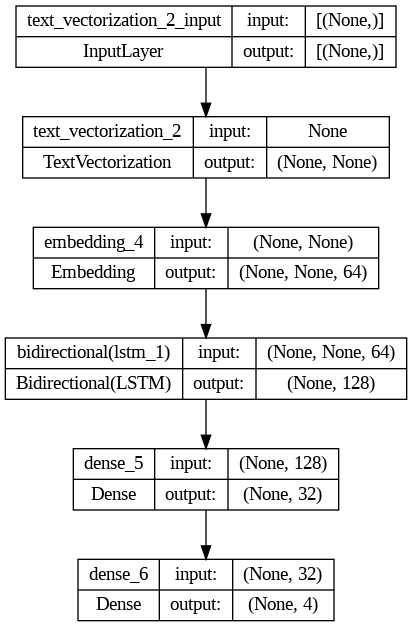

In [42]:
# compiling the model

model_rnn_bidir_lstm.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                             metrics = ['accuracy'])

tf.keras.utils.plot_model(model_rnn_bidir_lstm, show_shapes = True)

In [43]:
rnn_bidir_lstm_history = model_rnn_bidir_lstm.fit(train_ds, validation_data = val_ds, epochs = EPOCHS)

Epoch 1/20
100/100 [==============================] - 33s 242ms/step - loss: 1.3854 - accuracy: 0.2697 - val_loss: 1.3840 - val_accuracy: 0.3113
Epoch 2/20
100/100 [==============================] - 4s 42ms/step - loss: 1.3677 - accuracy: 0.3483 - val_loss: 1.3317 - val_accuracy: 0.4019
Epoch 3/20
100/100 [==============================] - 5s 52ms/step - loss: 1.2430 - accuracy: 0.4392 - val_loss: 1.2257 - val_accuracy: 0.4169
Epoch 4/20
100/100 [==============================] - 5s 48ms/step - loss: 1.0760 - accuracy: 0.5353 - val_loss: 1.0345 - val_accuracy: 0.6044
Epoch 5/20
100/100 [==============================] - 4s 42ms/step - loss: 0.9271 - accuracy: 0.6595 - val_loss: 0.9517 - val_accuracy: 0.6506
Epoch 6/20
100/100 [==============================] - 6s 58ms/step - loss: 0.7938 - accuracy: 0.7180 - val_loss: 0.8598 - val_accuracy: 0.6731
Epoch 7/20
100/100 [==============================] - 4s 42ms/step - loss: 0.6933 - accuracy: 0.7586 - val_loss: 0.8387 - val_accuracy: 0.68

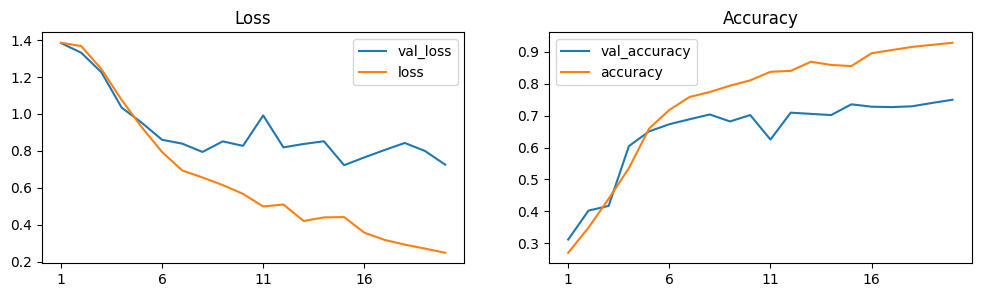

In [44]:
model_comparison['rnn_bidir_lstm'] = pd.DataFrame(rnn_bidir_lstm_history.history)
plot_performance('rnn_bidir_lstm')

this model showed a slightly better performance than the simple LSTM model. In the next step, we compare all models.

# Comparing models

In [53]:
# the list of all models:
models = [bow_model, word_embedding_model, word_embedding_regul_model, simple_rnn_model, rnn_lstm_model, model_rnn_bidir_lstm]

# evaluating the performance of all models on the validation set
loss = []
accuracy = []
for model in models:
  metrics = model.evaluate(val_ds, return_dict=True)
  loss.append(metrics['loss'])
  accuracy.append(metrics['accuracy'])



25/25 [==============================] - 1s 23ms/step - loss: 0.7249 - accuracy: 0.7500


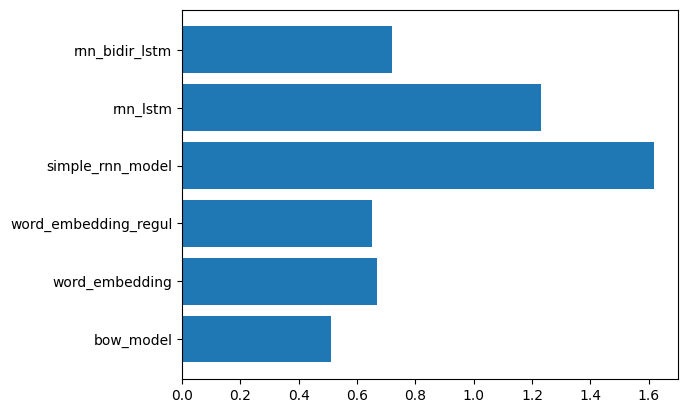

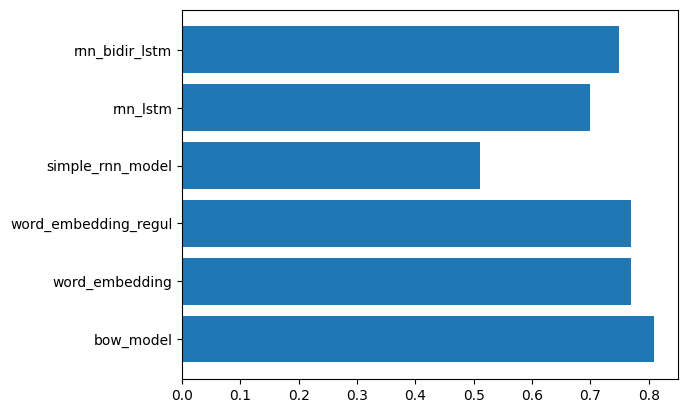

In [70]:
comparison = pd.DataFrame({"model": list(model_comparison.keys()), "loss" : np.round(loss,2), "accuracy": np.round(accuracy,2)})

# visulizing the performance
plt.barh(comparison['model'], comparison['loss'])
plt.show()

plt.barh(comparison['model'], comparison['accuracy'])
plt.show()

# Conclusion
Although the bag of words model was the simplest model, it showed a better perfromance than other more complex models. It shows that more advanced and complex models always won't outperform simpler models.